In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
sns.set()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 20)

In [23]:
df = pd.read_csv('../shared_datasets/survey_results_public.csv')

### Get dataframe with columns important to us:
- **Respondent**: Randomized respondent ID number (not in order of survey response time)
- **ConvertedComp**: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
- **YearsCode**: Including any education, how many years have you been coding?
- **Age**: What is your age (in years)? If you prefer not to answer, you may leave this question blank.
- **OrgSize**: Approximately how many people are employed by the company or organization you work for?
- **Gender**: Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
- **Ethnicity**: Which of the following do you identify as? Please check all that apply. If you prefer not to answer, you may leave this question blank.
- **LanguageWorkedWith**: Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
- **Country**: In which country do you currently reside?
- **WorkWeekHrs**: On average, how many hours per week do you work?
- **Extraversion**: Do you prefer online chat or IRL conversations?
- **Dependents**: Do you have any dependents (e.g., children, elders, or others) that you care for?

### Run .py files

In [24]:
%run ../shared_datasets/clean_dataframe.py

In [25]:
dataframe_class = CleanDataframe(df)
df_cleaned = dataframe_class.cleaned_df

In [26]:
df_cleaned

,Respondent,ConvertedComp,WorkWeekHrs,YearsCode,Age,CodeRevHrs,YearsCodePro,learned_code,Assembly,Bash/Shell/PowerShell,C,C#,...,Continent_South America,Gender_Woman:Dependents_Yes,White or of European descent:Gender_Man,Biracial:Gender_Woman,Black or of African descent:Gender_Woman,East Asian:Gender_Woman,Hispanic or Latino/Latina:Gender_Woman,Middle Eastern:Gender_Woman,Multiracial:Gender_Woman,"Native American, Pacific Islander, or Indigenous Australian:Gender_Woman",South Asian:Gender_Woman,ImpSyn_Far above average:Gender_Man
13,14,57060.0,40.0,13,31.0,4.0,2,18.0,0,0,0,0,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,17,65277.0,45.0,5,29.0,5.0,2,24.0,0,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,19,31140.0,8.0,14,31.0,3.0,13,17.0,0,0,0,1,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22,23,69000.0,40.0,3,22.0,8.0,1,19.0,0,1,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,29,100000.0,40.0,4,32.0,2.0,2,28.0,0,1,0,0,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88298,88850,120000.0,40.0,14,34.0,3.0,11,20.0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88300,88852,3000.0,84.0,4,31.0,2.0,3,27.0,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88301,88853,110000.0,36.0,8,27.0,4.0,6,19.0,0,1,0,1,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88323,88876,180000.0,40.0,8,23.0,3.0,2,15.0,0,1,0,1,...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
df_cleaned[df_cleaned['ConvertedComp'] < 2000].sort_values('ConvertedComp', ascending=True)
# df_cleaned[df_cleaned['ConvertedComp'] > 490000].sort_values('ConvertedComp', ascending=True)

,Respondent,ConvertedComp,WorkWeekHrs,YearsCode,Age,CodeRevHrs,YearsCodePro,learned_code,Assembly,Bash/Shell/PowerShell,C,C#,...,Continent_South America,Gender_Woman:Dependents_Yes,White or of European descent:Gender_Man,Biracial:Gender_Woman,Black or of African descent:Gender_Woman,East Asian:Gender_Woman,Hispanic or Latino/Latina:Gender_Woman,Middle Eastern:Gender_Woman,Multiracial:Gender_Woman,"Native American, Pacific Islander, or Indigenous Australian:Gender_Woman",South Asian:Gender_Woman,ImpSyn_Far above average:Gender_Man
6784,6813,1000.0,44.0,5,23.0,10.0,1,18.0,1,1,1,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84253,84778,1008.0,40.0,0,23.0,10.0,0,23.0,0,0,1,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53179,53518,1020.0,45.0,3,24.0,5.0,0,21.0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3026,3040,1044.0,48.0,14,32.0,10.0,6,18.0,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4639,4662,1080.0,50.0,10,26.0,1.0,4,16.0,0,1,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9937,9979,1100.0,40.0,10,30.0,2.0,10,20.0,0,1,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31178,31365,1132.0,40.0,4,29.0,10.0,4,25.0,0,1,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16798,16889,1140.0,60.0,15,33.0,5.0,10,18.0,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78671,79163,1140.0,72.0,7,23.0,8.0,3,16.0,1,1,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12064,12120,1140.0,50.0,8,26.0,3.0,5,18.0,0,0,1,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
list(df_cleaned.columns)

['Respondent',
 'ConvertedComp',
 'WorkWeekHrs',
 'YearsCode',
 'Age',
 'CodeRevHrs',
 'YearsCodePro',
 'learned_code',
 'Assembly',
 'Bash/Shell/PowerShell',
 'C',
 'C#',
 'C++',
 'Clojure',
 'Dart',
 'Elixir',
 'Erlang',
 'F#',
 'Go',
 'HTML/CSS',
 'Java',
 'JavaScript',
 'Kotlin',
 'Objective-C',
 'Other(s):',
 'PHP',
 'Python',
 'R',
 'Ruby',
 'Rust',
 'SQL',
 'Scala',
 'Swift',
 'TypeScript',
 'VBA',
 'WebAssembly',
 'LanguageWorkedWith_Total',
 'Biracial',
 'Black or of African descent',
 'East Asian',
 'Hispanic or Latino/Latina',
 'Middle Eastern',
 'Multiracial',
 'Native American, Pacific Islander, or Indigenous Australian',
 'South Asian',
 'White or of European descent',
 'OrgSize_1,000 to 4,999 employees',
 'OrgSize_10 to 19 employees',
 'OrgSize_10,000 or more employees',
 'OrgSize_100 to 499 employees',
 'OrgSize_2-9 employees',
 'OrgSize_20 to 99 employees',
 'OrgSize_5,000 to 9,999 employees',
 'OrgSize_500 to 999 employees',
 'OrgSize_Just me - I am a freelancer, sole

In [29]:
len(list(df_cleaned.columns))

295

In [17]:
corr = df_cleaned.corr()

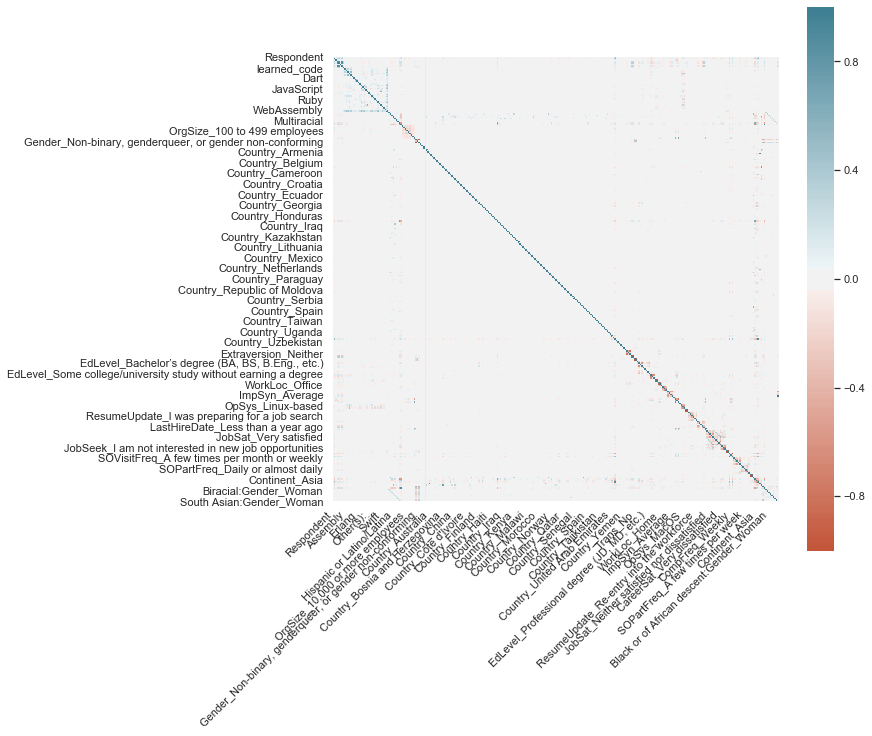

In [18]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


Slope: [[0.00066089]]
Intercept: [70331.01384019]
Root mean squared error:  3882395744.1580462
R2 score:  7.403380342108079e-08


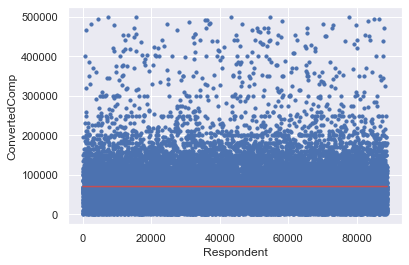

In [19]:
# generate random data-set
np.random.seed(0)
x = df_cleaned[['Respondent']]
y = df_cleaned[['ConvertedComp']]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
plt.scatter(x, y, s=10)
plt.xlabel(x.columns[0])
plt.ylabel(y.columns[0])

# predicted values
plt.plot(x, y_predicted, color='r')
plt.show()

In [20]:
df_cleaned[df_cleaned['ConvertedComp'] == 0].sort_values('ConvertedComp', ascending=True)

,Respondent,ConvertedComp,WorkWeekHrs,YearsCode,Age,CodeRevHrs,YearsCodePro,learned_code,Assembly,Bash/Shell/PowerShell,C,C#,...,Continent_South America,Gender_Woman:Dependents_Yes,White or of European descent:Gender_Man,Biracial:Gender_Woman,Black or of African descent:Gender_Woman,East Asian:Gender_Woman,Hispanic or Latino/Latina:Gender_Woman,Middle Eastern:Gender_Woman,Multiracial:Gender_Woman,"Native American, Pacific Islander, or Indigenous Australian:Gender_Woman",South Asian:Gender_Woman,ImpSyn_Far above average:Gender_Man


In [21]:
# scratch work
# cleaned_df = df[['Respondent','ConvertedComp',
#                  'YearsCode','Age','WorkWeekHrs']].dropna()

# df_test = cleaned_df.groupby('Gender')['Respondent'].nunique()
# df_test

# cleaned_df[cleaned_df['ConvertedComp'] >= 1000000].sort_values('Age', ascending=True)
# df_converted_comp = pd.DataFrame(cleaned_df[['Respondent', 'YearsCode', 'Age']])
# troll = df_converted_comp[ (df_converted_comp['YearsCode'] < 10) ].index

# cleaned_df['ConvertedComp'].describe()
# test = cleaned_df.sort_values('Age', ascending=True)[:650]
# test
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age')
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age').describe()
# list_of_unique_countries = cleaned_df['Country'].unique()

# list_of_unique_continent = cleaned_df['Continent'].unique()
# foo = cleaned_df[ cleaned_df['Respondent'] == 1438 ]
# foo = cleaned_df.sort_values('WorkWeekHrs', ascending=False)
# foo
# foo.describe()
# df_test = cleaned_df.groupby('WorkWeekHrs')['Respondent'].nunique()
# df_test
# x = np.random.rand(100, 1)
# y = 2 + 3 * x + np.random.rand(100, 1)
# x = cleaned_df.drop(columns=['ConvertedComp'])
# x = cleaned_df[cleaned_df['calc_age'] > 18]
# y = cleaned_df[(cleaned_df['calc_age'] > 18) & (cleaned_df['ConvertedComp'])]